In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import gc
import time

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
/kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
/kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z


In [3]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!unzip -o /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip -o /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip




p7zip is already the newest version (16.02+dfsg-7build1).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge/                                                           1 file, 77912192 bytes (75 MiB)

Extracting archive: /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
--
Path = /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - train.tsv                  6% - train.t

In [4]:
df = pd.read_csv("train.tsv", low_memory=False, sep='\t')

In [5]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.shape, test.shape

((1186028, 8), (296507, 8))

Text(0.5, 1.0, 'Price Distribution')

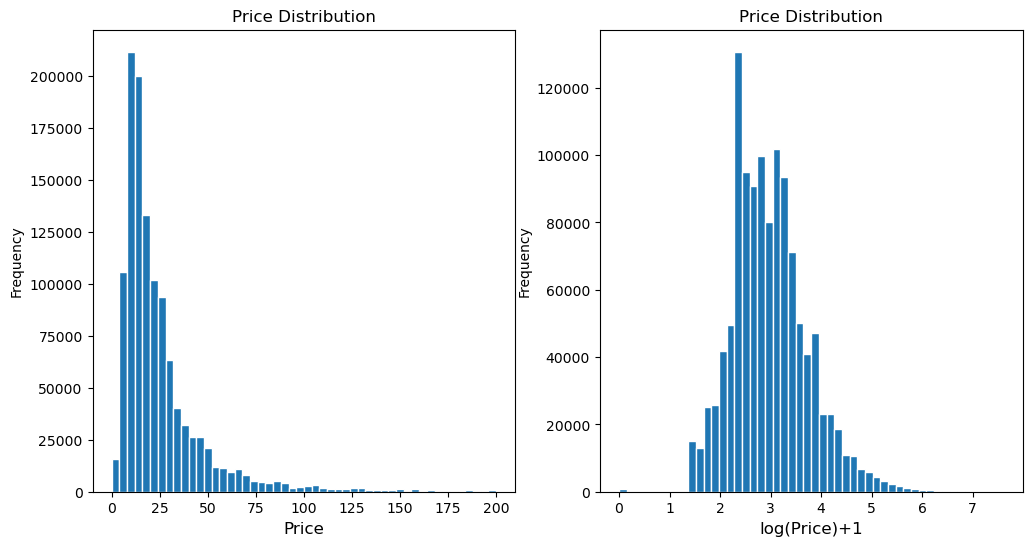

In [7]:
plt.subplot(1,2,1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range= [0,200])
plt.xlabel('Price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1,2,2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white')
plt.xlabel('log(Price)+1', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [8]:
train['shipping'].value_counts()/len(train) *100

0    55.28318
1    44.71682
Name: shipping, dtype: float64

In [9]:
fee_buyer = train.loc[df['shipping'] ==0, 'price']
fee_seller = train.loc[df['shipping']==1, 'price']
print("The avg. Price is {}".format(round(fee_seller.mean(), 2)), "when seller pays the shipping");
print("The avg. Price is {}".format(round(fee_buyer.mean(), 2)), "when buyer pays the shipping")

The avg. Price is 22.53 when seller pays the shipping
The avg. Price is 30.07 when buyer pays the shipping


In [10]:
train['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

<AxesSubplot:xlabel='item_condition_id', ylabel='price'>

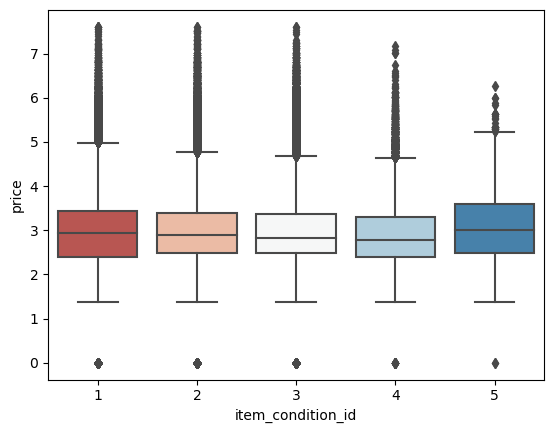

In [11]:
sns.boxplot(x = 'item_condition_id', y =np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

In [12]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 500000

In [13]:
train['category_name'].isnull().sum()

5083

In [14]:
train['brand_name'].isnull().sum()

506058

In [15]:
train['item_description'].isnull().sum()

3

In [16]:
train['price'].isnull().sum()

0

In [17]:
train['item_condition_id'].isnull().sum()

0

In [18]:
def heandel_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].replace('No description yet,''missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)
    
    
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

    
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [19]:
df = pd.read_csv("train.tsv", sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price !=0].reset_index(drop=True)

In [20]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [21]:
heandel_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [22]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
x_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
x_category = cv.fit_transform(merge['category_name'])

In [23]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [24]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [25]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [26]:
sparse_merge = hstack((X_dummies, X_description, X_brand, x_category, x_name)).tocsr()

In [27]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) -1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [28]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [29]:
train_X =lgb.Dataset(X, label=y)

In [30]:
params = {
    'learning_rate': 0.75,
    'application': 'regression',
    'max_depth': 3,
    'num_leaves': 100,
    'verbosity': -1,
    'metric': 'RMSE',
}

In [31]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200,verbose_eval=100)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [32]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [33]:
mean_squared_error(y_test, y_pred)

0.2143398489956353